### Treść zadania

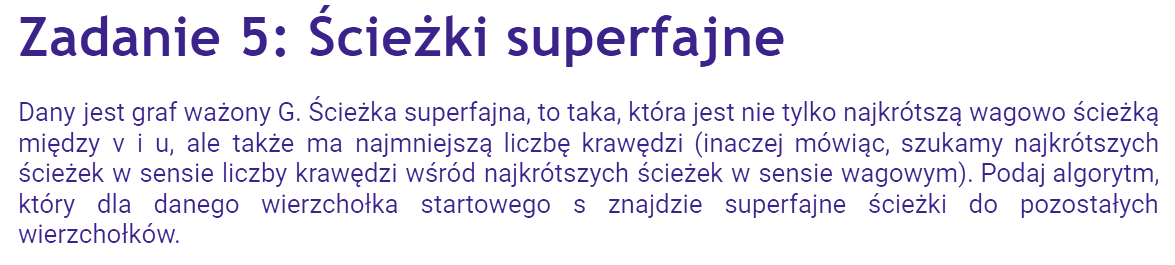

## Implementacja #1
#### (Dla listowej reprezentacji grafu)

### Omówienie algorytmu

Wykorzystujemy nieco przerobiony algorytm Dijkstry w taki sposób, aby w przypadku, gdy mamy kilka ścieżek o tej samej wadze (sumarycznej długości wagowej), wybierał on zawsze tę, która ma najmniejszą sumaryczną liczbę krawędzi. Modyfikacja jest prosta i polega jedynie na dodaniu drugiego priorytetu do kolejki priorytetowej. Ponieważ spośród ścieżek najkrótszych wagowo wybieramy te, które mają najmniej krawędzi, pierwszym priorytetem jest sumaryczna waga ścieżki, a drugim - liczba krawędzi na ścieżce. Kolejka priorytetowa zajmie się już za nas rozwiązaniem sytuacji konfliktowej i wybierze zawsze tę ścieżkę spośród najkrótszych wagowo, dla której drugi priorytet (liczba krawędzi) ma najmniejszą wartość.

### Złożoność

###### Obliczeniowa:
$ O(E \cdot log(V)) $ - jak algorytm Dijkstry
###### Pamięciowa:
$ O(V) $ - pamięci zajmowanej przez dany na wejściu graf nie wliczam do złożoności

### Algorytm

In [1]:
from queue import PriorityQueue


def dijkstra(G: 'graph represented by adjacency lists', s: 'source'):
    n = len(G)
    inf = float('inf')
    weights  = [inf] * n
    parents  = [None] * n
    # This variable is a counter of vertices remaining which we still
    # have to find shortest paths to
    to_relax = n
    pq = PriorityQueue()
    pq.put((0, 0, s, s))
    parents[s] = s

    while not pq.empty() and to_relax:
        min_w, e_count, u, parent = pq.get()
        # We will find the minimum total weight path only once so the
        # code below this if statement will be executed only once
        # (A priority queue is sorted by both: total weight of a path
        # and total number of edges in a path, so if there is more than
        # one path of the same total weight, we will always poll the one
        # of the lower number of edges)
        if min_w < weights[u]:
            weights[u]  = min_w
            parents[u]  = parent
            to_relax -= 1
            # Add all the neighbours of the u vertex to the priority queue
            for v, weight in G[u]:
                if parents[v] is None:
                    pq.put((min_w + weight, e_count + 1, v, u))
                
    return weights, parents


"""Dodatkowo: Odtważanie wybranej najkrótszej ścieżki z wierzchołka s do wskazanego innego wierzchołka"""
def get_path_init(G, s: 'source'):
    weights, parents = dijkstra(G, s)
    
    def get_path(t: 'target'):
        path = []
        
        u = t
        while u != s:
            path.append(u)
            u = parents[u]
        path.append(s)
        
        path.reverse()
        return path, weights[t]
    
    return get_path

###### Kilka testów

##### Pomocnicze:

In [2]:
def undirected_weighted_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append((e[1], e[2]))
        G[e[1]].append((e[0], e[2]))
    return G

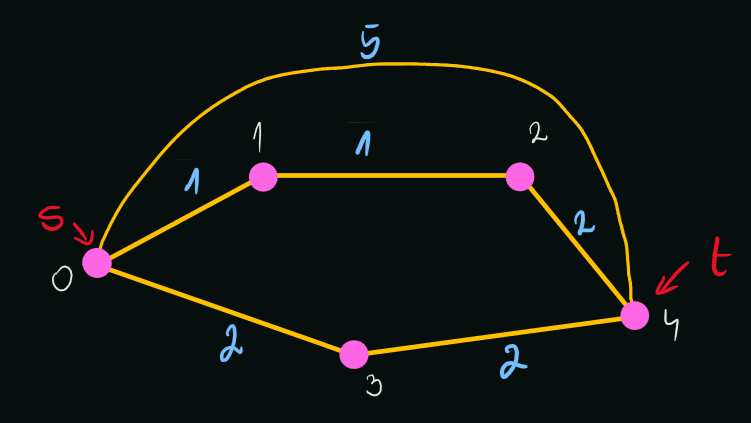

In [3]:
E = [(0, 4, 5), (0, 3, 2), (1, 0, 1), (1, 2, 1), (4, 2, 2), (3, 4, 2)]
G = undirected_weighted_graph_list(E)

s = 0

get_path = get_path_init(G, s)

print(dijkstra(G, s))
print(get_path(4))
print(get_path(2))

([0, 1, 2, 2, 4], [0, 0, 1, 0, 3])
([0, 3, 4], 4)
([0, 1, 2], 2)


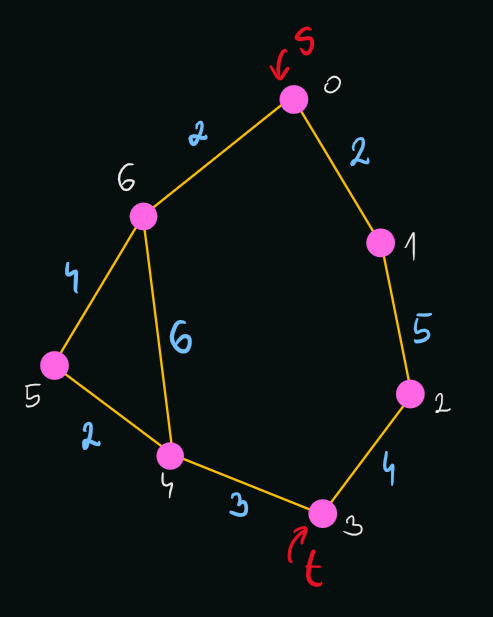

In [4]:
E = [(0, 1, 2), (1, 2, 5), (2, 3, 4), (0, 6, 2), (6, 5, 4), (6, 4, 6), (5, 4, 2), (4, 3, 3)]
G = undirected_weighted_graph_list(E)

s = 0

get_path = get_path_init(G, s)

print(dijkstra(G, s))
print(get_path(4))
print(get_path(3))

([0, 2, 7, 11, 8, 6, 2], [0, 0, 1, 2, 6, 6, 0])
([0, 6, 4], 8)
([0, 1, 2, 3], 11)


## Implementacja #2
#### (Dla macierzowej reprezentacji grafu)

### Omówienie algorytmu

Wykorzystujemy zmodyfikowny algorytm Dijkstry dla macierzowej reprezentacji grafu, którego idea oraz implementacja zostały dokładnie wytłumaczone <a href="../../Zadania z wykładu/Algorytmy grafowe/[Grafowe] Algorytm Dijsktry - najkrótsze ścieżki jeden do wszystkich, tylko nieujemne wagi.ipynb 
">TUTAJ</a>. Modyfikacja polega na tym, że rozpatrujemy jeszcze jeden warunek podczas wyboru kolejnego do przetworzenia wierzchołka i zawsze wybieramy ten spośród wierzchołków o najmniejszym oszacowaniu odległości, dla którego również liczba krawędzi na ścieżce jest najmniejsza.

### Złożoność

###### Obliczeniowa:
$ O(V^2) $ - jak algorytm Dijkstry dla reprezentacji macierzowej grafu
###### Pamięciowa:
$ O(V) $ - pamięci zajmowanej przez dany na wejściu graf nie wliczam do złożoności

### Algorytm

In [5]:
class Node:
    def __init__(self, idx=None):
        self.idx  = idx
        self.next = None


def vertices_to_process_ll(n):
    head = Node()
    tail = head
    for i in range(n):
        tail.next = Node(i)
        tail = tail.next
    return head


def get_next_vertex(head, weights, lengths):
    if not head.next: return None  # If no more vertices are remaining
    
    # Find a vertex of the lowest weight
    min_prev = head
    prev = head.next
    while prev.next:
        u = prev.next.idx
        v = min_prev.next.idx
        if weights[u] < weights[v] or (weights[u] == weights[v] and lengths[u] < lengths[v]):
            min_prev = prev
        prev = prev.next
        
    # Remove a vertex found
    u = min_prev.next.idx
    min_prev.next = min_prev.next.next
    
    return u


def dijkstra(G: 'graph represented by adjacency matrix', s: 'source'):
    n = len(G)
    inf = float('inf')
    # Store information about vertices which haven't been processed yet
    to_process = vertices_to_process_ll(n)
    parents    = [None] * n
    weights    = [inf] * n
    lengths    = [inf] * n  # Numbers of edges
    weights[s] = lengths[0] = 0
    
    # Loop till there are some vertices which haven't been processed yet
    while True:
        # Find a vertex of the minimum total weight path (if there is more than
        # one vertex, choose the one of a lower number of edges on the path)
        u = get_next_vertex(to_process, weights, lengths)
        # Check if we exhausted all the vertices
        if u is None: break
        # Iterate over the vertice's neighbours and update weights of the paths
        for v in range(n):
            # Skip if no edge (-1 means not edge)
            if G[u][v] == -1: continue
            # Update the weight of a path to the vertex v if found a better one
            if weights[u] + G[u][v] < weights[v]:
                weights[v] = weights[u] + G[u][v]
                lengths[v] = lengths[u] + 1
                parents[v] = u
                
    return weights, parents


"""
Dodatkowo: Odtważanie wybranej najkrótszej ścieżki z wierzchołka s do wskazanego innego wierzchołka
(algorytm identyczny jak wyżej)
"""
def get_path_init(G, s: 'source'):
    weights, parents = dijkstra(G, s)
    
    def get_path(t: 'target'):
        path = []
        
        u = t
        while u:
            path.append(u)
            u = parents[u]
        path.append(s)
        
        return path[::-1], weights[t]
    
    return get_path

###### Kilka testów

##### Pomocnicze:

In [6]:
def undirected_weighted_graph_matrix(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[-1] * n for _ in range(n)]  # -1 means no edge
    for e in E:
        G[e[0]][e[1]] = e[2]
        G[e[1]][e[0]] = e[2]
    return G

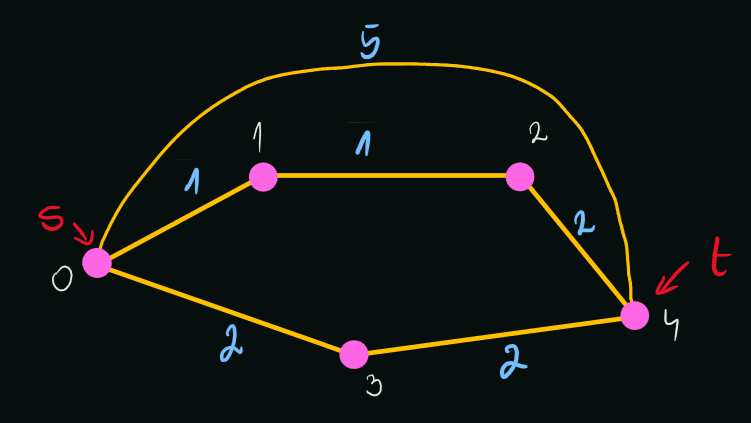

In [7]:
E = [(0, 4, 5), (0, 3, 2), (1, 0, 1), (1, 2, 1), (4, 2, 2), (3, 4, 2)]
G = undirected_weighted_graph_matrix(E)

s = 0

get_path = get_path_init(G, s)

print(dijkstra(G, s))
print(get_path(4))
print(get_path(2))

([0, 1, 2, 2, 4], [None, 0, 1, 0, 3])
([0, 3, 4], 4)
([0, 1, 2], 2)


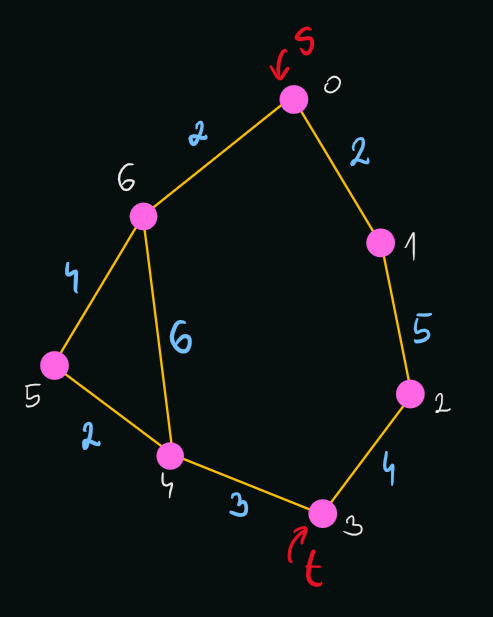

In [8]:
E = [(0, 1, 2), (1, 2, 5), (2, 3, 4), (0, 6, 2), (6, 5, 4), (6, 4, 6), (5, 4, 2), (4, 3, 3)]
G = undirected_weighted_graph_matrix(E)

s = 0

get_path = get_path_init(G, s)

print(dijkstra(G, s))
print(get_path(4))
print(get_path(3))

([0, 2, 7, 11, 8, 6, 2], [None, 0, 1, 2, 6, 6, 0])
([0, 6, 4], 8)
([0, 1, 2, 3], 11)
